# Cluster Mouse Movements Using Basic Features

### Imports and Setup

In [1]:
# Imports
import pandas as pd
import numpy as np
import math
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from matplotlib import pyplot as plt

In [2]:
# HugginFace datasets library (~600,000 rows)
DATASET_URL = "hf://datasets/dejanseo/mouse_movement_tracking/mouse.parquet"

### Data Pre/post-processing, Plotting, and Helper Functions

In [3]:
def visualize_clusters(df: pd.DataFrame, feature: str, labels: np.ndarray, n_clusters: int) -> None:
    """Visualize clusters for a single feature."""
    plt.figure(figsize=(8, 6))
    plt.scatter(df.index, df[feature], c=labels, cmap='viridis', s=10)
    plt.title(f"Clusters for {feature} (k={n_clusters})")
    plt.xlabel("Index")
    plt.ylabel(feature)
    plt.colorbar(label="Cluster")
    plt.show()

def plot_1d_hist(df: pd.DataFrame, feature: str, labels: np.ndarray, n_clusters: int) -> None:
    """Plot 1D histogram of a feature with cluster labels."""
    X = df[[feature]].values  # shape (n_samples, 1)
    plt.figure(figsize=(6,4))
    for cluster in np.unique(labels):
        plt.hist(X[labels == cluster].ravel(),
                 bins=50, alpha=0.5,
                 label=f"Cluster {cluster}")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(f"{feature} clusters (k={n_clusters})")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [4]:
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """Preprocess the data by renaming columns and cleaning up NaNs."""
    #cleaning up data
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Drop rows with NaNs or fill them appropriately
    df.dropna(inplace=True)

    # Optional: filter out rows with 0 speed or distance if that’s noise
    df = df[(df['speed'] > 0) & (df['distance'] > 0)]

    return df

def postprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """Post-process the data by applying transformations to features."""
    # 1% Winsorization: clip 1st and 99th percentiles
    for feat in ['speed_quantile_ratio','pause_ratio']:
        low, high = df[feat].quantile([0.01, 0.99])
        df[feat] = df[feat].clip(low, high)

    # Remove negative values; shouldnt exist but just in case
    df[feat] = df[feat].clip(lower=0)

    # Log transformation to reduce skewness
    df[feat] = np.log1p(df[feat])
    df[feat].replace([np.inf, -np.inf], np.nan, inplace=True)
    df[feat].fillna(0, inplace=True)

    return df

def session_direction_entropy(angles: np.ndarray, n_bins: int = 8) -> float:
    """
    Calculate the Shannon entropy of the angles
    i.e. discretize the angles into bins and computes the entropy

    NOTES:
    Shannon entropy is a measure of uncertainty or randomness in the data.
    In this case, it quantifies the diversity of angles in the session.
    For example, a session with a lot of different angles (i.e., a lot of different directions) will have high entropy,
    while a session with very few angles (i.e., mostly straight lines) will have low entropy.
    """
    hist, _ = np.histogram(angles, bins=n_bins, range=(-math.pi, math.pi), density=True)
    hist = hist + 1e-8                # avoid zeros
    return -np.sum(hist * np.log(hist))

### Feature Extraction

In [5]:
def extract_clustering_features(df: pd.DataFrame) -> pd.DataFrame:
    ### OLD SIMPLE METHOD ###
    # # Calculate distance moved
    # df['distance'] = np.sqrt((df['x'].diff() ** 2) + (df['y'].diff() ** 2))

    # # Calculate time difference between consecutive points
    # df['time_diff'] = df['timestamp'].diff()

    # # Calculate speed
    # df['speed'] = df['distance'] / df['time_diff']

    # # Calculate acceleration
    # df['acceleration'] = df['speed'].diff() / df['time_diff']
    # df['acceleration'].replace([np.inf, -np.inf], np.nan, inplace=True)

    # # Calculate jerk (change in acceleration)
    # df['jerk'] = df['acceleration'].diff() / df['time_diff']

    # # Calculate direction (angle in radians)
    # df['direction'] = np.arctan2(df['y'].diff(), df['x'].diff())

    # # Fill NaN values caused by diff()
    # df.fillna(0, inplace=True)
    ##########################
    """
    Compute per-session aggregates:
    - speed 10th/90th percentile → quantile ratio
    - direction entropy
    - pause ratio
    - click rate
    """
    # Ensure raw point‐level features exist (x, y, timestamp, type)
    df['distance']  = np.hypot(df['x'].diff(), df['y'].diff())
    df['time_diff'] = df['timestamp'].diff().fillna(0)
    df['speed']     = df['distance'] / df['time_diff'].replace(0, np.nan)
    df['speed'].fillna(0, inplace=True)
    # angle of motion
    df['angle'] = np.arctan2(df['y'].diff(), df['x'].diff()).fillna(0)
    # pause flag: idle > 500 ms
    df['is_pause']  = (df['time_diff'] > 500).astype(int)
    # click flag
    df['click_event'] = (df['type'] == 'click').astype(int)

    # Aggregate features per session
    sess = df.groupby('session_id').agg(
        speed_p10   = ('speed', lambda x: np.percentile(x, 10)),
        speed_p90   = ('speed', lambda x: np.percentile(x, 90)),
        angles      = ('angle', list),
        total_time  = ('time_diff', 'sum'),
        pause_time  = ('time_diff', lambda x: x[x > 500].sum()),
        click_count = ('click_event', 'sum'),
    )

    # Derive features
    sess['speed_quantile_ratio'] = sess['speed_p90'] / (sess['speed_p10'] + 1e-8)
    sess['direction_entropy']    = sess['angles'].apply(session_direction_entropy)
    sess['pause_ratio']          = sess['pause_time'] / (sess['total_time'] + 1e-8)
    sess['click_rate']           = sess['click_count'] / (sess['total_time'] + 1e-8)

    # Keep only what we need for clustering and reset index to get session_id back as a column
    final_df = sess[
        ['speed_quantile_ratio','direction_entropy','pause_ratio','click_rate']
    ].reset_index()

    return final_df

### Clustering with k-means

In [6]:
def cluster_mouse_data(df: pd.DataFrame, n_clusters=[2,3,4,5]) -> None:
    """Cluster mouse movement data using KMeans and evaluate with silhouette score."""
    # Sample subset of the data for faster processing
    # df = df.sample(n=5_000, random_state=42)

    features = [
        # 'acceleration',
        # 'jerk',
        "speed_quantile_ratio",
        "direction_entropy",
        "pause_ratio",
        "click_rate",
    ]

    # only keep features with >1 unique value
    features = [
        f
        for f in ["speed_quantile_ratio","direction_entropy","pause_ratio","click_rate"]
        if df[f].nunique() > 1
    ]

    # scaler = StandardScaler()  # Scale features to have mean=0 and std=1
    scaler = RobustScaler()  # Scale features using median and IQR to reduce the influence of outliers
    results = []

    # Iterate over each feature and perform clustering
    for feat in features:
        X = scaler.fit_transform(df[[feat]].values)  # shape (n_samples, 1)

        # attempt different numbers of clusters
        for k in n_clusters:
            print(f"Clustering '{feat}' with k={k}...")
            km = KMeans(n_clusters=k, random_state=42, n_init="auto")
            labels = km.fit_predict(X)

            # only compute silhouette if we actually got at least 2 clusters
            unique_labels = np.unique(labels)
            if len(unique_labels) < 2:
                print(f"  → only {len(unique_labels)} distinct cluster(s), skipping silhouette.")
                score = np.nan
            else:
                score = silhouette_score(X, labels)

            results.append({
                "feature": feat,
                "n_clusters": k,
                "silhouette": score
            })

            # Visualize clusters for the current feature and k
            print(f"  -> silhouette score: {score:.3f}")
            visualize_clusters(df, feat, labels, k)
            # plot_1d_hist(df, feat, labels, k)

    results_df = pd.DataFrame(results)
    print(results_df)

### Main Driver Code

In [8]:
# Load dataset
df = pd.read_parquet(DATASET_URL)

In [10]:
# Preprocess the data
df = preprocess_data(df)

In [11]:
# Extract features
df = extract_clustering_features(df)

In [12]:
# Post-process the data
df = postprocess_data(df)

Clustering mouse data...
Clustering 'speed_quantile_ratio' with k=2...
  -> silhouette score: 0.925


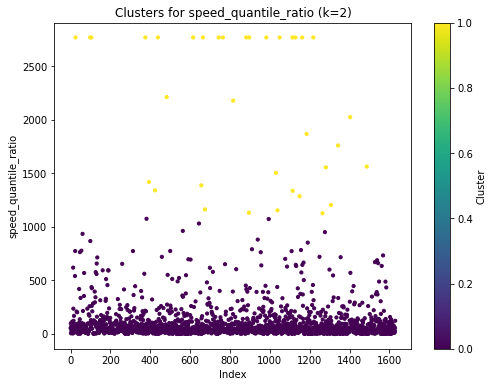

Clustering 'speed_quantile_ratio' with k=3...
  -> silhouette score: 0.840


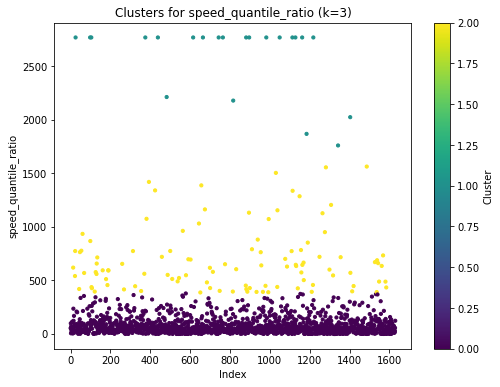

Clustering 'speed_quantile_ratio' with k=4...
  -> silhouette score: 0.747


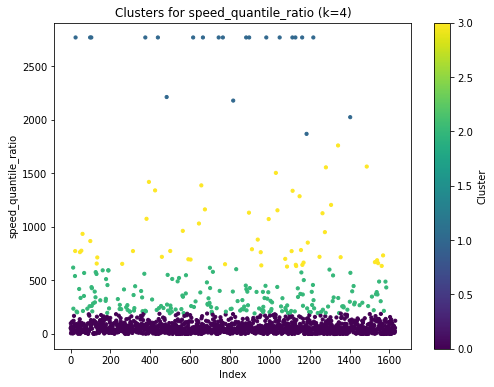

Clustering 'speed_quantile_ratio' with k=5...
  -> silhouette score: 0.725


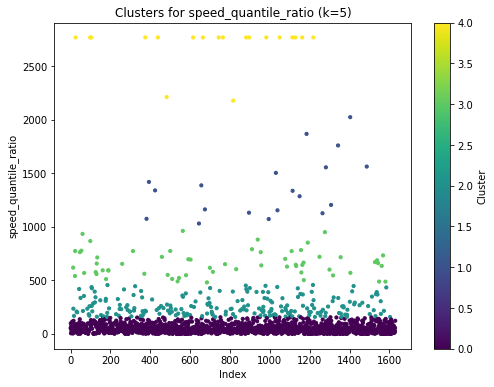

Clustering 'direction_entropy' with k=2...
  -> silhouette score: 0.707


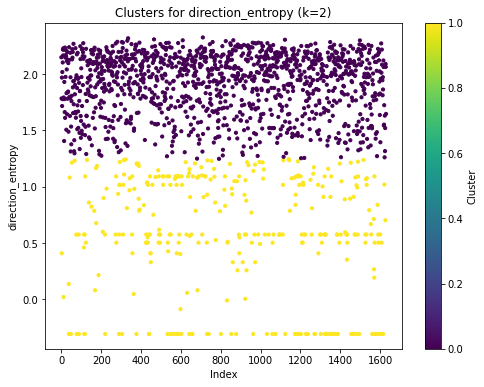

Clustering 'direction_entropy' with k=3...
  -> silhouette score: 0.643


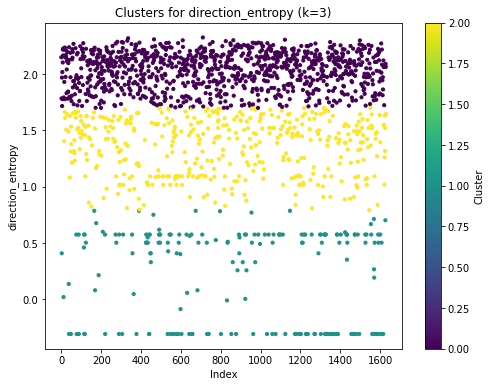

Clustering 'direction_entropy' with k=4...
  -> silhouette score: 0.629


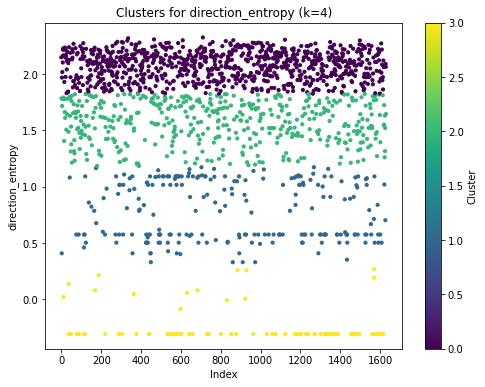

Clustering 'direction_entropy' with k=5...
  -> silhouette score: 0.616


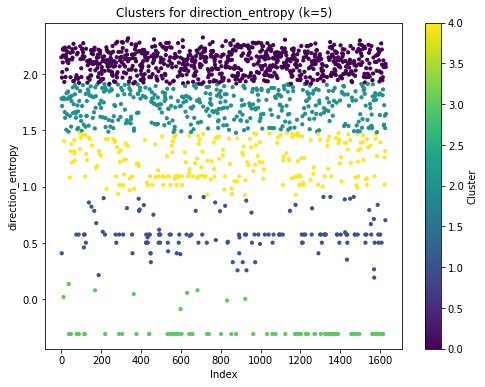

Clustering 'pause_ratio' with k=2...
  -> silhouette score: 0.909


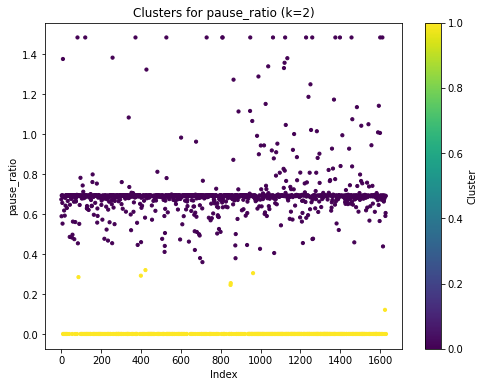

Clustering 'pause_ratio' with k=3...
  -> silhouette score: 0.921


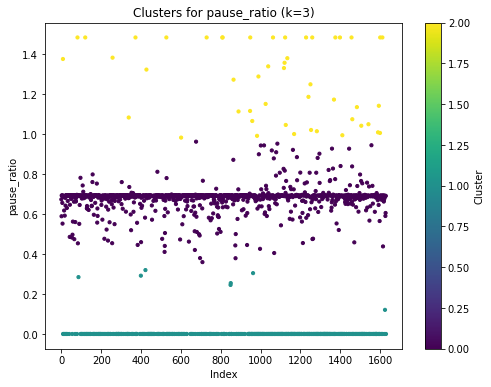

Clustering 'pause_ratio' with k=4...
  -> silhouette score: 0.898


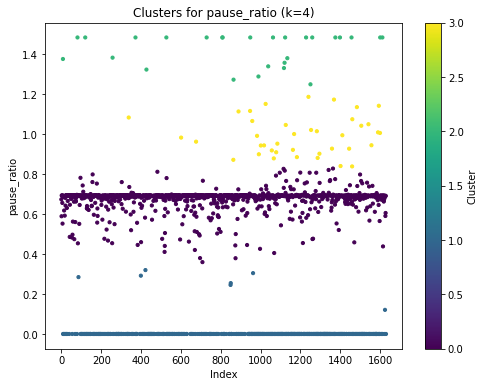

Clustering 'pause_ratio' with k=5...
  -> silhouette score: 0.880


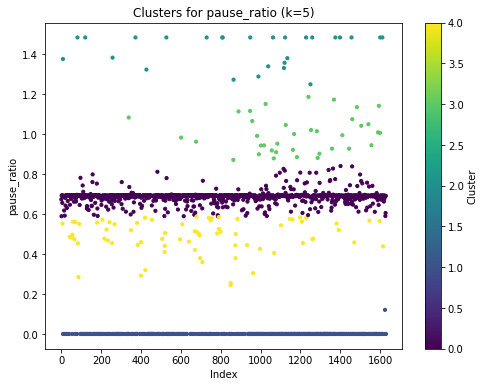

                 feature  n_clusters  silhouette
0   speed_quantile_ratio           2    0.924670
1   speed_quantile_ratio           3    0.840366
2   speed_quantile_ratio           4    0.747272
3   speed_quantile_ratio           5    0.725233
4      direction_entropy           2    0.706823
5      direction_entropy           3    0.642650
6      direction_entropy           4    0.629200
7      direction_entropy           5    0.615506
8            pause_ratio           2    0.908916
9            pause_ratio           3    0.921436
10           pause_ratio           4    0.897556
11           pause_ratio           5    0.879815


In [13]:
# Cluster data using KMeans
print("Clustering mouse data...")
cluster_mouse_data(df)